## CSCIE89 Robust Outlier Detection using Autoencoder on MNIST Dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
EPOCHS = 20
BATCH_SIZE = 128
ENCODING_DIM = 32
OUTLIER_FRACTION = 0.01  # 1% of data will be outliers

print("="*80)
print("OUTLIER DETECTION USING AUTOENCODER ON MNIST")
print("="*80)

# ============================================================================
# 1. LOAD AND PREPROCESS DATA
# ============================================================================
print("\n[1] Loading MNIST dataset...")
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize to [0, 1] range (better for sigmoid activation in output)
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

print(f"Training set: {train_images.shape}")
print(f"Test set: {test_images.shape}")



OUTLIER DETECTION USING AUTOENCODER ON MNIST

[1] Loading MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set: (60000, 28, 28)
Test set: (10000, 28, 28)


In [2]:
# ============================================================================
# 2. CREATE OUTLIER INJECTION STRATEGIES
# ============================================================================
def inject_outliers_v1_overlay(images, indices, overlay_fraction=0.5):
    """Overlay two random images (original method, improved)"""
    outliers = images.copy()
    for idx in indices:
        # Select a random different image
        random_idx = np.random.randint(0, len(images))
        while random_idx == idx:
            random_idx = np.random.randint(0, len(images))

        # Overlay with controllable blending
        outliers[idx] = np.clip(
            outliers[idx] + overlay_fraction * images[random_idx],
            0, 1
        )
    return outliers

def inject_outliers_v2_noise(images, indices, noise_level=0.5):
    """Add Gaussian noise"""
    outliers = images.copy()
    for idx in indices:
        noise = np.random.normal(0, noise_level, images[idx].shape)
        outliers[idx] = np.clip(outliers[idx] + noise, 0, 1)
    return outliers

def inject_outliers_v3_corrupted(images, indices, corruption_fraction=0.3):
    """Randomly corrupt pixels (salt-and-pepper noise)"""
    outliers = images.copy()
    for idx in indices:
        mask = np.random.random(images[idx].shape) < corruption_fraction
        outliers[idx] = np.where(mask, np.random.random(images[idx].shape), outliers[idx])
    return outliers

def inject_outliers_v4_inverted(images, indices):
    """Invert the image colors"""
    outliers = images.copy()
    for idx in indices:
        outliers[idx] = 1.0 - outliers[idx]
    return outliers

def inject_outliers_v5_blocked(images, indices, block_size=14):
    """Replace random blocks with noise"""
    outliers = images.copy()
    for idx in indices:
        h, w = images[idx].shape
        y = np.random.randint(0, h - block_size)
        x = np.random.randint(0, w - block_size)
        outliers[idx][y:y+block_size, x:x+block_size] = np.random.random((block_size, block_size))
    return outliers



In [3]:
# ============================================================================
# 3. PREPARE TEST DATA WITH MULTIPLE OUTLIER TYPES
# ============================================================================
print("\n[3] Injecting outliers into test data...")

# Create clean test data copy
clean_test_images = test_images.copy()

# Determine number of outliers per type
n_test = len(test_images)
n_outliers_per_type = int(n_test * OUTLIER_FRACTION / 5)  # 5 types

# Initialize arrays
contaminated_test_images = test_images.copy()
outlier_labels = np.zeros(n_test, dtype=int)  # 0 = normal, 1 = outlier
outlier_types = np.zeros(n_test, dtype=int)  # Which type of outlier

# Inject different types of outliers
start_idx = 0
outlier_methods = [
    ("Overlay", inject_outliers_v1_overlay),
    ("Gaussian Noise", inject_outliers_v2_noise),
    ("Corrupted Pixels", inject_outliers_v3_corrupted),
    ("Inverted Colors", inject_outliers_v4_inverted),
    ("Blocked Regions", inject_outliers_v5_blocked)
]

for type_idx, (method_name, inject_func) in enumerate(outlier_methods, 1):
    indices = np.arange(start_idx, start_idx + n_outliers_per_type)
    contaminated_test_images = inject_func(contaminated_test_images, indices)
    outlier_labels[indices] = 1
    outlier_types[indices] = type_idx
    start_idx += n_outliers_per_type
    print(f"  ✓ Injected {n_outliers_per_type} outliers using: {method_name}")

print(f"\nTotal outliers: {np.sum(outlier_labels)} ({np.sum(outlier_labels)/n_test*100:.2f}%)")
print(f"Clean samples: {n_test - np.sum(outlier_labels)}")




[3] Injecting outliers into test data...
  ✓ Injected 20 outliers using: Overlay
  ✓ Injected 20 outliers using: Gaussian Noise
  ✓ Injected 20 outliers using: Corrupted Pixels
  ✓ Injected 20 outliers using: Inverted Colors
  ✓ Injected 20 outliers using: Blocked Regions

Total outliers: 100 (1.00%)
Clean samples: 9900


In [4]:
# ============================================================================
# 4. BUILD AUTOENCODER MODEL
# ============================================================================
print("\n[4] Building autoencoder model...")

def build_autoencoder(input_shape=(28, 28), encoding_dim=32):
    """Build a robust autoencoder for outlier detection"""

    # Encoder
    encoder_input = layers.Input(shape=input_shape, name='input_image')
    x = layers.Flatten()(encoder_input)
    x = layers.Dense(128, activation='relu', name='encoder_dense1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu', name='encoder_dense2')(x)
    x = layers.BatchNormalization()(x)
    encoded = layers.Dense(encoding_dim, activation='relu', name='bottleneck')(x)

    # Decoder
    x = layers.Dense(64, activation='relu', name='decoder_dense1')(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu', name='decoder_dense2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(784, activation='sigmoid', name='decoder_output')(x)
    decoded = layers.Reshape(input_shape, name='output_image')(x)

    # Models
    autoencoder = keras.Model(encoder_input, decoded, name='autoencoder')
    encoder = keras.Model(encoder_input, encoded, name='encoder')

    return autoencoder, encoder

autoencoder, encoder = build_autoencoder(encoding_dim=ENCODING_DIM)
autoencoder.summary()

# Compile model
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['mae']
)




[4] Building autoencoder model...


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense1 (Dense)          │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense1 (Dense)          │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense2 (Dense)          │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 784)            │       101,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_image (Reshape)          │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,920 (874.69 KB)

 Trainable params: 223,152 (871.69 KB)

 Non-trainable params: 768 (3.00 KB)

In [5]:
# ============================================================================
# 5. TRAIN AUTOENCODER ON CLEAN DATA ONLY
# ============================================================================
print("\n[5] Training autoencoder on clean training data...")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

history = autoencoder.fit(
    train_images, train_images,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=2
)

print(f"Training completed!")
print(f"Final training loss: {history.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")




[5] Training autoencoder on clean training data...
Epoch 1/20
422/422 - 11s - 25ms/step - loss: 0.2700 - mae: 0.1689 - val_loss: 0.1486 - val_mae: 0.0756 - learning_rate: 1.0000e-03
Epoch 2/20
422/422 - 5s - 12ms/step - loss: 0.1441 - mae: 0.0708 - val_loss: 0.1252 - val_mae: 0.0595 - learning_rate: 1.0000e-03
Epoch 3/20
422/422 - 6s - 14ms/step - loss: 0.1328 - mae: 0.0623 - val_loss: 0.1139 - val_mae: 0.0515 - learning_rate: 1.0000e-03
Epoch 4/20
422/422 - 5s - 12ms/step - loss: 0.1266 - mae: 0.0578 - val_loss: 0.1083 - val_mae: 0.0476 - learning_rate: 1.0000e-03
Epoch 5/20
422/422 - 6s - 15ms/step - loss: 0.1231 - mae: 0.0553 - val_loss: 0.1058 - val_mae: 0.0457 - learning_rate: 1.0000e-03
Epoch 6/20
422/422 - 5s - 12ms/step - loss: 0.1209 - mae: 0.0536 - val_loss: 0.1030 - val_mae: 0.0438 - learning_rate: 1.0000e-03
Epoch 7/20
422/422 - 6s - 15ms/step - loss: 0.1193 - mae: 0.0525 - val_loss: 0.1013 - val_mae: 0.0427 - learning_rate: 1.0000e-03
Epoch 8/20
422/422 - 9s - 21ms/step -

In [6]:
# ============================================================================
# 6. COMPUTE RECONSTRUCTION ERRORS
# ============================================================================
print("\n[6] Computing reconstruction errors...")

# Reconstruct clean test images
reconstructed_clean = autoencoder.predict(clean_test_images, verbose=0)
clean_errors = np.mean(np.abs(clean_test_images - reconstructed_clean), axis=(1, 2))

# Reconstruct contaminated test images
reconstructed_contaminated = autoencoder.predict(contaminated_test_images, verbose=0)
contaminated_errors = np.mean(np.abs(contaminated_test_images - reconstructed_contaminated), axis=(1, 2))

print(f"Clean data - Mean error: {np.mean(clean_errors):.6f} ± {np.std(clean_errors):.6f}")
print(f"All data - Mean error: {np.mean(contaminated_errors):.6f} ± {np.std(contaminated_errors):.6f}")
print(f"Outliers - Mean error: {np.mean(contaminated_errors[outlier_labels==1]):.6f}")
print(f"Normal - Mean error: {np.mean(contaminated_errors[outlier_labels==0]):.6f}")




[6] Computing reconstruction errors...
Clean data - Mean error: 0.036949 ± 0.013326
All data - Mean error: 0.039194 ± 0.034433
Outliers - Mean error: 0.261776
Normal - Mean error: 0.036945


In [7]:
# ============================================================================
# 7. EVALUATE OUTLIER DETECTION PERFORMANCE
# ============================================================================
print("\n[7] Evaluating outlier detection performance...")

# Calculate ROC AUC
auc_score = roc_auc_score(outlier_labels, contaminated_errors)
print(f"ROC AUC Score: {auc_score:.4f}")

# Calculate PR AUC
precision, recall, _ = precision_recall_curve(outlier_labels, contaminated_errors)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.4f}")

# Find optimal threshold using validation data
threshold = np.percentile(clean_errors, 95)  # 95th percentile of clean data
print(f"Detection threshold (95th percentile): {threshold:.6f}")

# Classify using threshold
predictions = (contaminated_errors > threshold).astype(int)
true_positives = np.sum((predictions == 1) & (outlier_labels == 1))
false_positives = np.sum((predictions == 1) & (outlier_labels == 0))
true_negatives = np.sum((predictions == 0) & (outlier_labels == 0))
false_negatives = np.sum((predictions == 0) & (outlier_labels == 1))

precision_score = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall_score = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1 = 2 * (precision_score * recall_score) / (precision_score + recall_score) if (precision_score + recall_score) > 0 else 0

print(f"\nConfusion Matrix:")
print(f"  True Positives:  {true_positives:5d}  |  False Positives: {false_positives:5d}")
print(f"  False Negatives: {false_negatives:5d}  |  True Negatives:  {true_negatives:5d}")
print(f"\nMetrics:")
print(f"  Precision: {precision_score:.4f}")
print(f"  Recall:    {recall_score:.4f}")
print(f"  F1-Score:  {f1:.4f}")



[7] Evaluating outlier detection performance...
ROC AUC Score: 0.9757
Precision-Recall AUC: 0.8624
Detection threshold (95th percentile): 0.059545

Confusion Matrix:
  True Positives:     92  |  False Positives:   494
  False Negatives:     8  |  True Negatives:   9406

Metrics:
  Precision: 0.1570
  Recall:    0.9200
  F1-Score:  0.2682



[8] Creating visualizations...
✓ Visualization saved as 'outlier_detection_results.png'


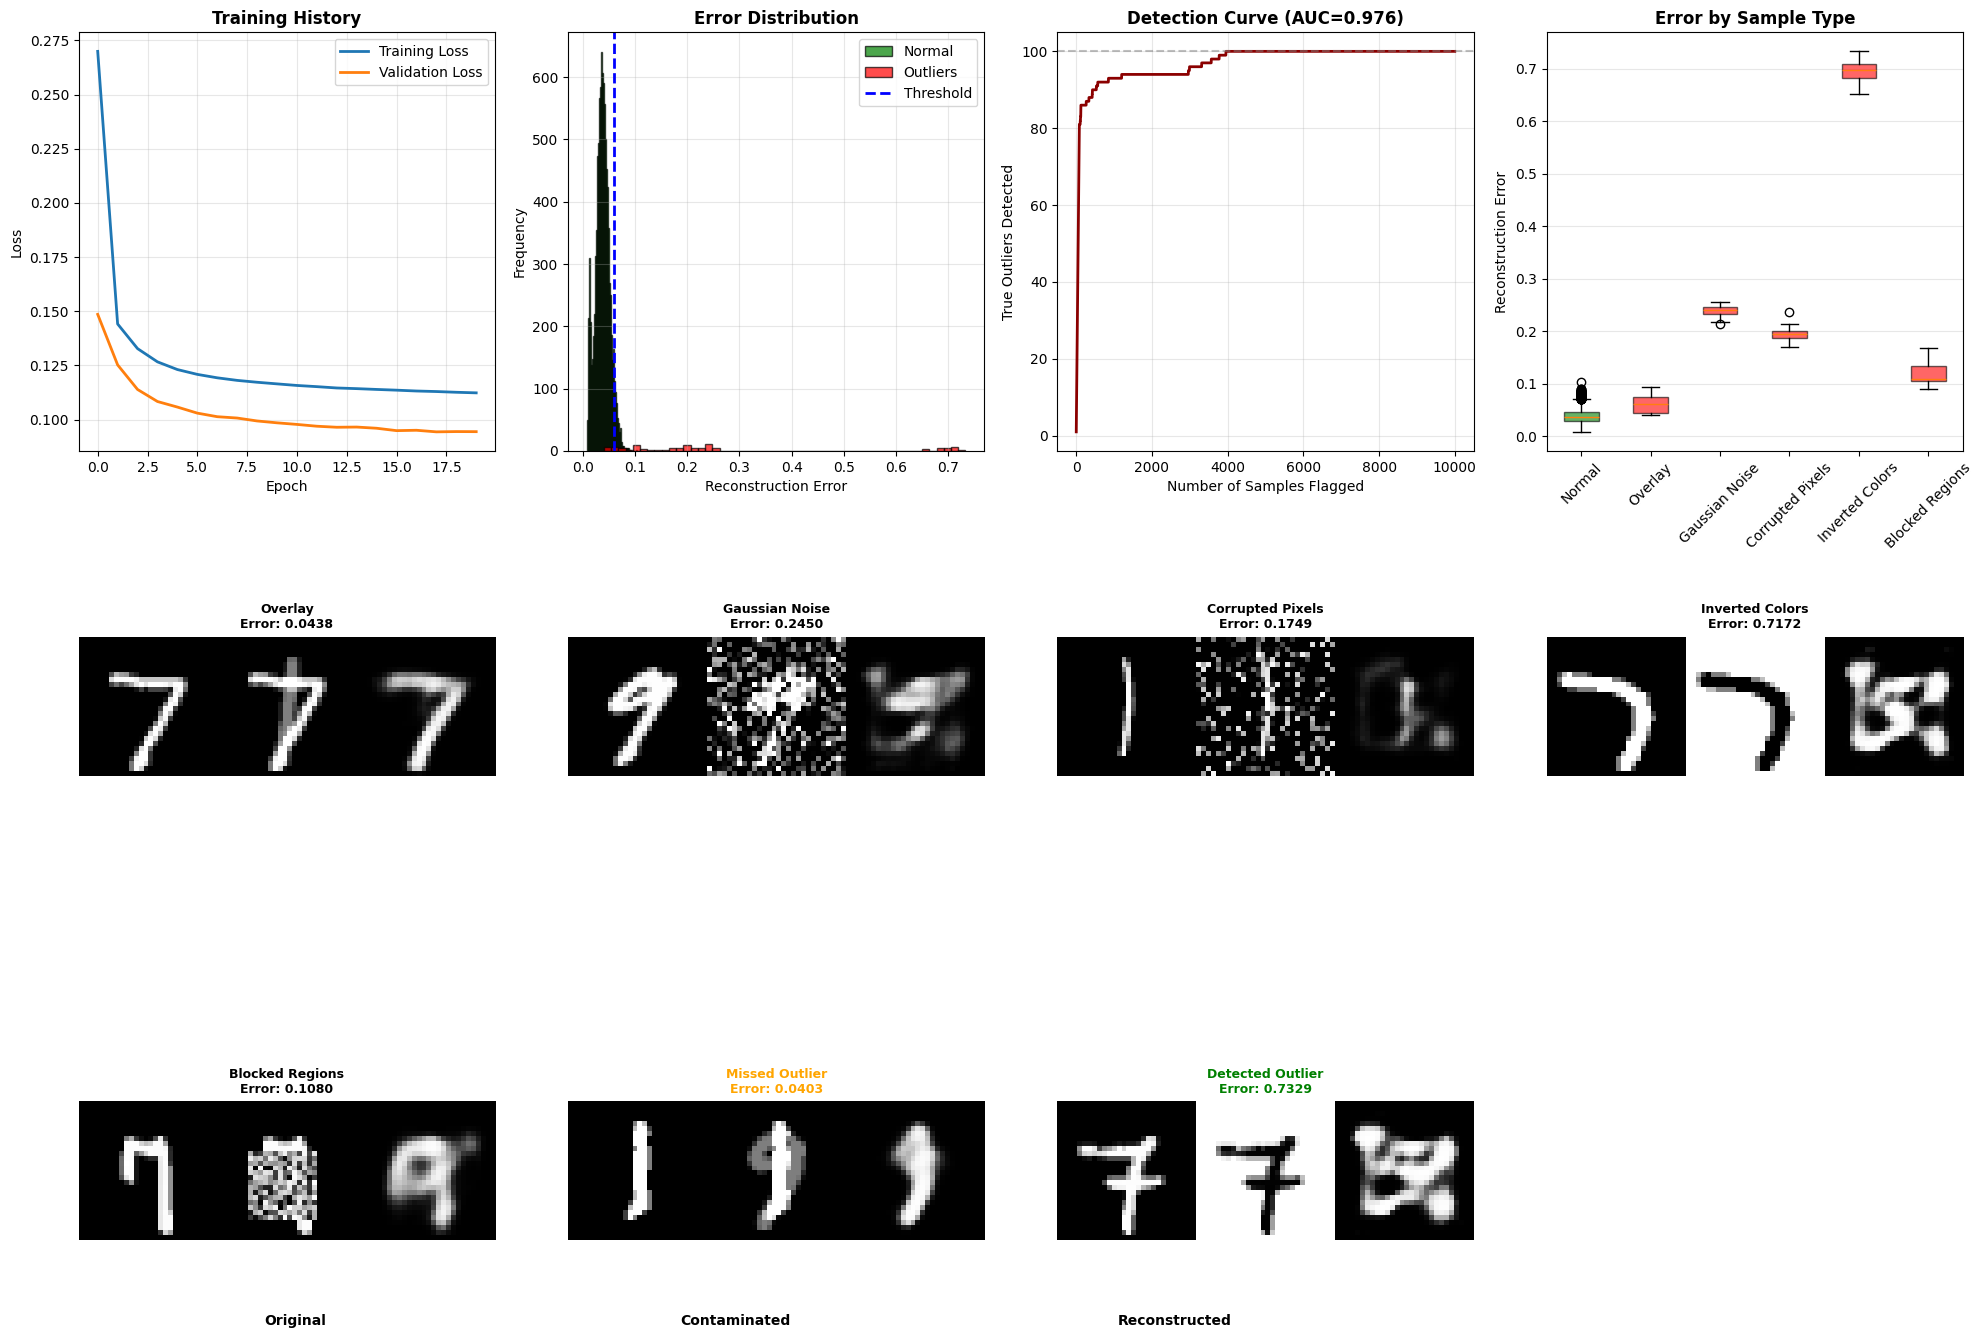

In [8]:

# ============================================================================
# 8. VISUALIZATIONS
# ============================================================================
print("\n[8] Creating visualizations...")

fig = plt.figure(figsize=(20, 14))

# 1. Training history
ax1 = plt.subplot(3, 4, 1)
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training History', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Reconstruction error distribution
ax2 = plt.subplot(3, 4, 2)
ax2.hist(contaminated_errors[outlier_labels==0], bins=50, alpha=0.7,
         label='Normal', color='green', edgecolor='black')
ax2.hist(contaminated_errors[outlier_labels==1], bins=50, alpha=0.7,
         label='Outliers', color='red', edgecolor='black')
ax2.axvline(threshold, color='blue', linestyle='--', linewidth=2, label='Threshold')
ax2.set_xlabel('Reconstruction Error')
ax2.set_ylabel('Frequency')
ax2.set_title('Error Distribution', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. ROC-like curve (sorted errors)
ax3 = plt.subplot(3, 4, 3)
sorted_indices = np.argsort(contaminated_errors)[::-1]
cumulative_outliers = np.cumsum(outlier_labels[sorted_indices])
ax3.plot(cumulative_outliers, linewidth=2, color='darkred')
ax3.axhline(np.sum(outlier_labels), color='gray', linestyle='--', alpha=0.5)
ax3.set_xlabel('Number of Samples Flagged')
ax3.set_ylabel('True Outliers Detected')
ax3.set_title(f'Detection Curve (AUC={auc_score:.3f})', fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Error by outlier type
ax4 = plt.subplot(3, 4, 4)
error_by_type = []
type_names = ['Normal'] + [name for name, _ in outlier_methods]
for i in range(len(type_names)):
    if i == 0:
        error_by_type.append(contaminated_errors[outlier_labels==0])
    else:
        error_by_type.append(contaminated_errors[outlier_types==i])

bp = ax4.boxplot(error_by_type, labels=type_names, patch_artist=True)
for patch, color in zip(bp['boxes'], ['green'] + ['red']*5):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax4.set_ylabel('Reconstruction Error')
ax4.set_title('Error by Sample Type', fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3, axis='y')

# 5. Example visualizations for each outlier type
plot_idx = 5
for type_idx, (type_name, _) in enumerate(outlier_methods, 1):
    # Find an outlier of this type
    outlier_idx = np.where(outlier_types == type_idx)[0][0]

    ax = plt.subplot(3, 4, plot_idx)

    # Show original, contaminated, and reconstructed
    combined = np.hstack([
        clean_test_images[outlier_idx],
        contaminated_test_images[outlier_idx],
        reconstructed_contaminated[outlier_idx]
    ])

    ax.imshow(combined, cmap='gray')
    ax.set_title(f'{type_name}\nError: {contaminated_errors[outlier_idx]:.4f}',
                fontweight='bold', fontsize=9)
    ax.axis('off')
    plot_idx += 1

# Add text labels
fig.text(0.15, 0.05, 'Original', ha='center', fontsize=10, fontweight='bold')
fig.text(0.37, 0.05, 'Contaminated', ha='center', fontsize=10, fontweight='bold')
fig.text(0.59, 0.05, 'Reconstructed', ha='center', fontsize=10, fontweight='bold')

# Show best and worst detections
worst_fn_idx = np.where((predictions == 0) & (outlier_labels == 1))[0]
if len(worst_fn_idx) > 0:
    worst_fn = worst_fn_idx[np.argmin(contaminated_errors[worst_fn_idx])]

    ax = plt.subplot(3, 4, 10)
    combined = np.hstack([
        clean_test_images[worst_fn],
        contaminated_test_images[worst_fn],
        reconstructed_contaminated[worst_fn]
    ])
    ax.imshow(combined, cmap='gray')
    ax.set_title(f'Missed Outlier\nError: {contaminated_errors[worst_fn]:.4f}',
                fontweight='bold', fontsize=9, color='orange')
    ax.axis('off')

best_tp_idx = np.where((predictions == 1) & (outlier_labels == 1))[0]
if len(best_tp_idx) > 0:
    best_tp = best_tp_idx[np.argmax(contaminated_errors[best_tp_idx])]

    ax = plt.subplot(3, 4, 11)
    combined = np.hstack([
        clean_test_images[best_tp],
        contaminated_test_images[best_tp],
        reconstructed_contaminated[best_tp]
    ])
    ax.imshow(combined, cmap='gray')
    ax.set_title(f'Detected Outlier\nError: {contaminated_errors[best_tp]:.4f}',
                fontweight='bold', fontsize=9, color='green')
    ax.axis('off')

plt.tight_layout()
plt.savefig('outlier_detection_results.png', dpi=150, bbox_inches='tight')
print("✓ Visualization saved as 'outlier_detection_results.png'")
plt.show()



In [9]:
# ============================================================================
# 9. TOP OUTLIERS SUMMARY
# ============================================================================
print("\n[9] Top 10 detected outliers:")
print("-" * 80)
top_outlier_indices = np.argsort(contaminated_errors)[::-1][:10]

for rank, idx in enumerate(top_outlier_indices, 1):
    is_true_outlier = "✓ TRUE OUTLIER" if outlier_labels[idx] == 1 else "✗ FALSE POSITIVE"
    type_str = type_names[outlier_types[idx]] if outlier_labels[idx] == 1 else "Normal"
    print(f"  Rank {rank:2d}: Index {idx:5d} | Error: {contaminated_errors[idx]:.6f} | "
          f"Type: {type_str:20s} | {is_true_outlier}")

print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"✓ Successfully detected outliers with ROC AUC = {auc_score:.4f}")
print(f"✓ Precision: {precision_score:.4f}, Recall: {recall_score:.4f}")
print(f"✓ The autoencoder learned normal patterns and flags anomalies")
print(f"✓ High reconstruction error → likely outlier")
print("="*80)


[9] Top 10 detected outliers:
--------------------------------------------------------------------------------
  Rank  1: Index    75 | Error: 0.732910 | Type: Inverted Colors      | ✓ TRUE OUTLIER
  Rank  2: Index    79 | Error: 0.718017 | Type: Inverted Colors      | ✓ TRUE OUTLIER
  Rank  3: Index    60 | Error: 0.717161 | Type: Inverted Colors      | ✓ TRUE OUTLIER
  Rank  4: Index    78 | Error: 0.715312 | Type: Inverted Colors      | ✓ TRUE OUTLIER
  Rank  5: Index    73 | Error: 0.711645 | Type: Inverted Colors      | ✓ TRUE OUTLIER
  Rank  6: Index    64 | Error: 0.708626 | Type: Inverted Colors      | ✓ TRUE OUTLIER
  Rank  7: Index    77 | Error: 0.708374 | Type: Inverted Colors      | ✓ TRUE OUTLIER
  Rank  8: Index    65 | Error: 0.706742 | Type: Inverted Colors      | ✓ TRUE OUTLIER
  Rank  9: Index    70 | Error: 0.702506 | Type: Inverted Colors      | ✓ TRUE OUTLIER
  Rank 10: Index    61 | Error: 0.699625 | Type: Inverted Colors      | ✓ TRUE OUTLIER

SUMMARY
✓ Success